In [16]:
device="cpu"
#device="cuda"
import io
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
from tqdm import trange

In [17]:
class CPU_Unpickler(pickle.Unpickler):
    import io
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


In [18]:
#brilliant-firecracker-222

file = open('results/brilliant-firecracker-222/BASIC.pkl', 'rb')
data = CPU_Unpickler(file).load()

In [19]:
data.keys()

dict_keys(['max_fits', 'ave_fits', 'st_div_fits', 'ave_complex', 'delta_fit_envchange', 'delta_fit_envchange_max', 'rebound_time', 'rebound_time_max', 'max_ages', 'ave_ages', 'best_grns', 'diversities', 'low', 'spec_A', 'spec_B', 'gen', 'kid_stds', 'args_used', 'IDs', 'id_stds', 'id_fits'])

In [20]:
IDs=data["IDs"]
id_stds=data["id_stds"]
id_fits=data["id_fits"]
args = data["args_used"]

In [23]:
IDs[-2]

tensor([[21329022, 21329022],
        [21329325, 21329325],
        [21330199, 21330199],
        ...,
        [21328111, 21374990],
        [21329365, 21375016],
        [21329180, 21374537]], dtype=torch.int32)

In [24]:
IDs[-3]

tensor([[21329022, 21329022],
        [21329325, 21329325],
        [21330199, 21330199],
        ...,
        [21328628, 21373680],
        [21334773, 21373896],
        [21329365, 21373616]], dtype=torch.int32)

In [71]:
#1. Pick switcher individual (early)
#2. Get downstream kid stds and fits
#3. Did it make it to the end? Stds? Fits?
#Repeat
top_switchers=torch.topk(data["id_stds"],10).indices
switcher_ID=top_switchers[4]
#switcher_ID=torch.argmax(data["id_stds"])
#data["id_stds"].max()
#data["id_fits"][switcher_ID]
switcher_ID

tensor(1746369)

In [72]:
# STARTING FROM INDV INDEX ANYWHERE - BACK AND FORTH AS FAR AS IT GOES
parent_id=switcher_ID
stds_before=[]
stds_before.append(id_stds[parent_id].item())
fits_before=[]
fits_before.append(id_fits[parent_id].item())
ids_before=[]
ids_before.append(parent_id)

found_g="NA"

#FIND STUFF BEFORE
for g in range(args.num_generations):
  if len(IDs[g][torch.where(IDs[g] == parent_id, True, False)]) > 0:
    found_g=g
    parent_id=IDs[g][torch.where(IDs[g][:,1] == parent_id, True, False)][0,0].item()
    while parent_id > 0:
      #record std
      stds_before.append(id_stds[parent_id].item())
      ids_before.append(parent_id)
      fits_before.append(id_fits[parent_id].item())
      g=g-1
      #find parent
      find_as_kid=torch.where(IDs[g][:,1] == parent_id, True, False)
      parent_id=IDs[g][find_as_kid][0,0].item()
  if found_g != "NA":
    break

parent_id=switcher_ID

# FIND STUFF AFTER
g=found_g+1
kids=IDs[g][torch.where(IDs[g][:,0] == parent_id, True, False)][:,1] # direct kids
if len(kids) > 0:
  g=g+1
  while g < args.num_generations:
    new_kids=IDs[g][sum(IDs[g][:,0]==i for i in kids).bool()][:,1]
    kids=torch.unique(torch.cat((kids, new_kids)))
    g=g+1

  ids_after=kids
  stds_after=id_stds[ids_after.tolist()]
  fits_after=id_fits[ids_after.tolist()]
else:
  print("no kids")

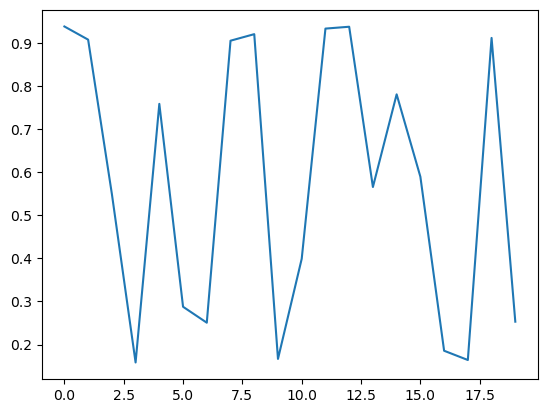

In [78]:
options=[ids_before, stds_before, fits_before, ids_after, stds_after, fits_after]
plt.plot(options[5])

In [8]:
last_gen=IDs[-2][:,0] #parents in the last gen

In [79]:

z = set(ids_after.tolist()).intersection(set(last_gen.tolist()))
if len(z)>0:
    print("survived")

In [ ]:
#1. Pick generalist individual (late)
#2. Get upstream ancestor stds and fits
#3. Did it come from switcher? Stds? Fits?
#Repeat

In [92]:
#id_fits[last_gen.tolist()] #no need to pick, at the end they are all the same generalist
gen_ID=last_gen.tolist()[1]
gen_ID

21329325

In [93]:
# STARTING FROM LAST INDIVIDUAL, RETRACE
parent_id=gen_ID

stds=[]
stds.append(id_stds[parent_id].item())
ids=[]
ids.append(parent_id)
fits=[]
fits.append(id_fits[parent_id].item())

for i in range(args.num_generations-2):  
  #find parent
  find_as_kid=torch.where(IDs[-(i+3)][:,1] == parent_id, True, False)
  parent_id=IDs[-(i+3)][find_as_kid][0,0].item()
  #record std
  stds.append(id_stds[parent_id].item())
  ids.append(parent_id)
  fits.append(id_fits[parent_id].item())

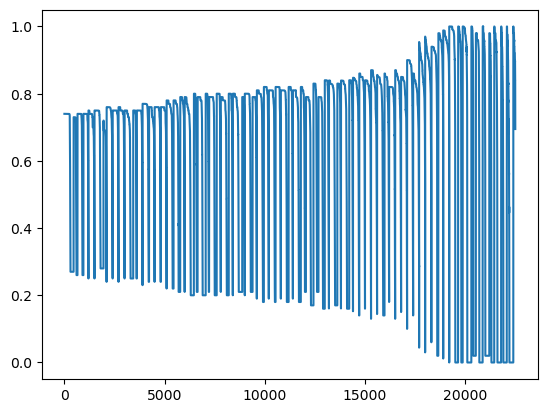

In [97]:
options=[ids, stds, fits]
plt.plot(options[2])

In [9]:
gen_ID=last_gen.tolist()
hist_ids=[]

for gid in trange(len(gen_ID)):
    parent_id=gen_ID[gid]

    ids=[]
    ids.append(parent_id)

    for i in range(args.num_generations-2):  
      #find parent
      find_as_kid=torch.where(IDs[-(i+3)][:,1] == parent_id, True, False)
      parent_id=IDs[-(i+3)][find_as_kid][0,0].item()
      #record std
      ids.append(parent_id)
    
    #print(max(stds))
    hist_ids.append(ids)

100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]


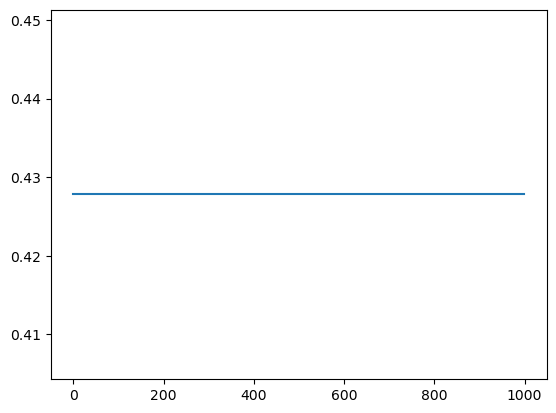

In [146]:
plt.plot(hist_ids)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hist_ids=np.load("hist_ids.npy")

In [4]:
def unzip(l):
    return list(zip(*l))

In [6]:
t=unzip(hist_ids)

In [5]:
len(unzip(hist_ids))

22499

In [35]:
lapo=hist_ids - hist_ids.min(axis=0)

In [64]:
hist_ids[:20,:3]

array([[21329022, 21329022, 21329022],
       [21329325, 21329325, 21329325],
       [21330199, 21330199, 21330199],
       [21331908, 21331908, 21331908],
       [21327564, 21327564, 21327564],
       [21330087, 21330087, 21330087],
       [21329284, 21329284, 21329284],
       [21331331, 21331331, 21331331],
       [21328623, 21328623, 21328623],
       [21331185, 21331185, 21331185],
       [21330843, 21330843, 21330843],
       [21329894, 21329894, 21329894],
       [21333038, 21333038, 21333038],
       [21330317, 21330317, 21330317],
       [21330215, 21330215, 21330215],
       [21328625, 21328625, 21328625],
       [21329365, 21329365, 21329365],
       [21329403, 21329403, 21329403],
       [21329238, 21329238, 21329238],
       [21330314, 21330314, 21330314]])

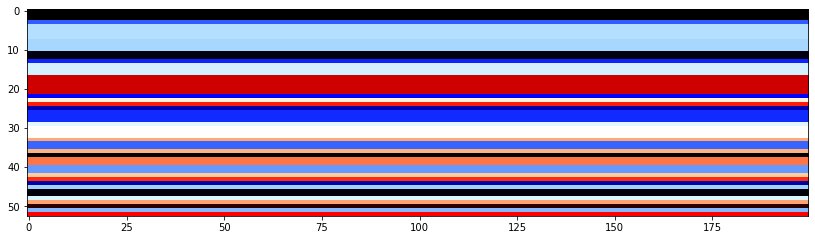

In [60]:
plt.figure(figsize=(14,6))
plt.imshow(hist_ids[:200,22446:].T,cmap="flag")
plt.show()

In [52]:
lapo[:,22446:].shape

(1000, 53)

In [45]:
np.where(lapo.sum(axis=0)[::-1].cumsum() == 0)[0].max()

22446

In [34]:
hist_ids - hist_ids.min(axis=0)

array([[2259, 2259, 2259, ...,    0,    0,    0],
       [2562, 2562, 2562, ...,    0,    0,    0],
       [3436, 3436, 3436, ...,    0,    0,    0],
       ...,
       [1348, 1348, 1348, ...,    0,    0,    0],
       [2602, 2602, 2602, ...,    0,    0,    0],
       [2417, 2417, 2417, ...,    0,    0,    0]])

In [29]:
for i in range(10):
    print(hist_ids[i])

[21329022 21329022 21329022 ...     2860     1603      407]
[21329325 21329325 21329325 ...     2860     1603      407]
[21330199 21330199 21330199 ...     2860     1603      407]
[21331908 21331908 21331908 ...     2860     1603      407]
[21327564 21327564 21327564 ...     2860     1603      407]
[21330087 21330087 21330087 ...     2860     1603      407]
[21329284 21329284 21329284 ...     2860     1603      407]
[21331331 21331331 21331331 ...     2860     1603      407]
[21328623 21328623 21328623 ...     2860     1603      407]
[21331185 21331185 21331185 ...     2860     1603      407]


In [15]:
np.save("hist_ids.npy",np.array(hist_ids))

In [14]:
import numpy as np

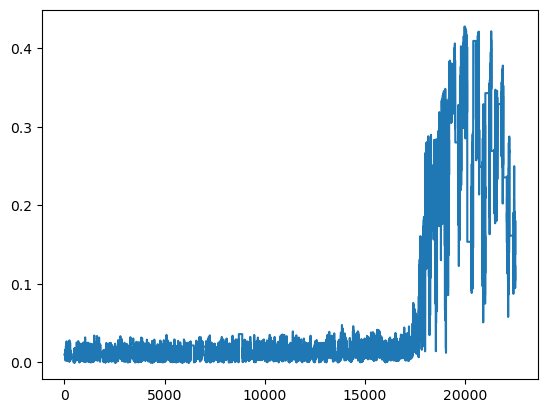

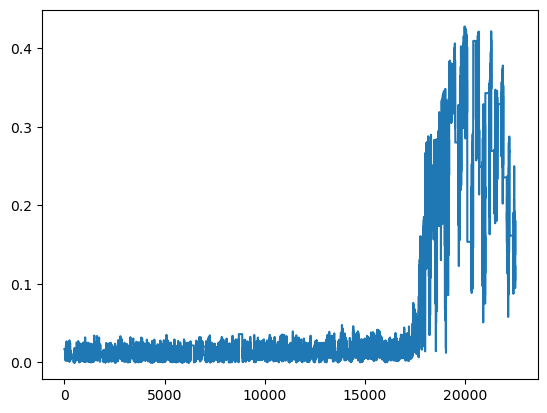

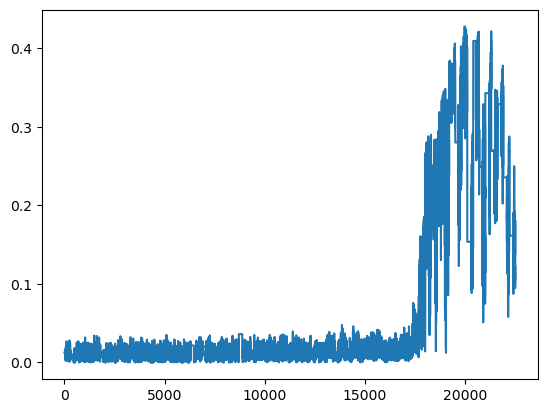

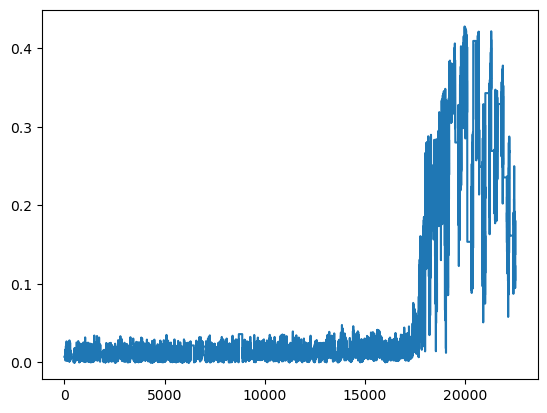

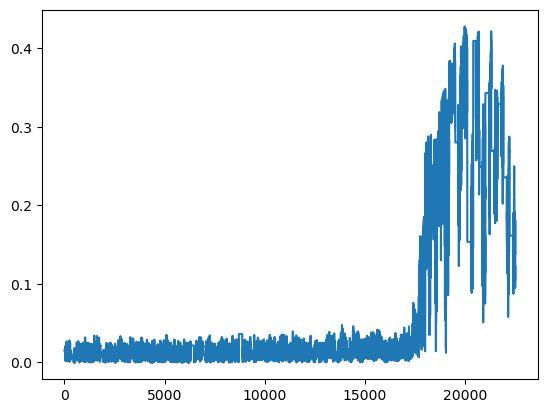

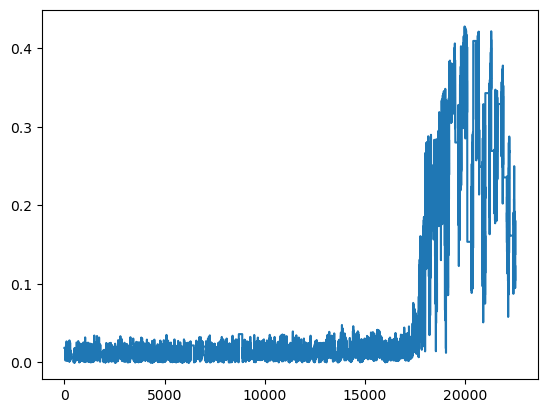

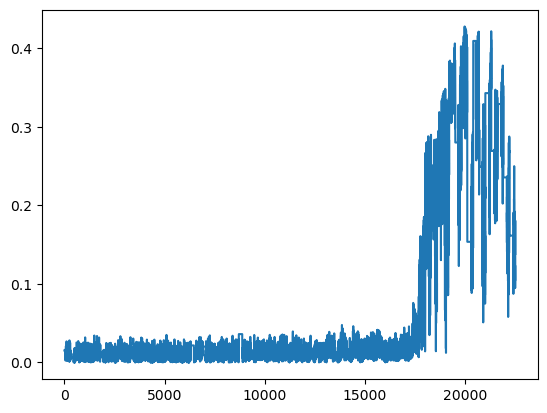

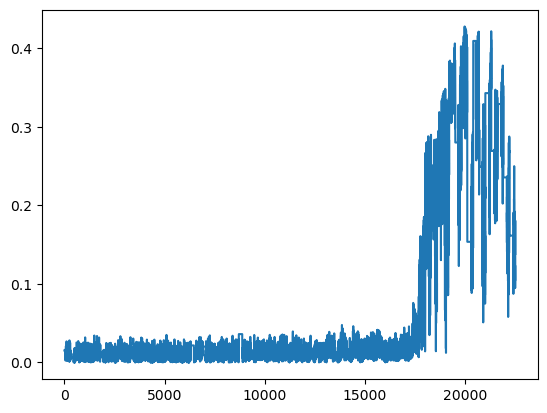

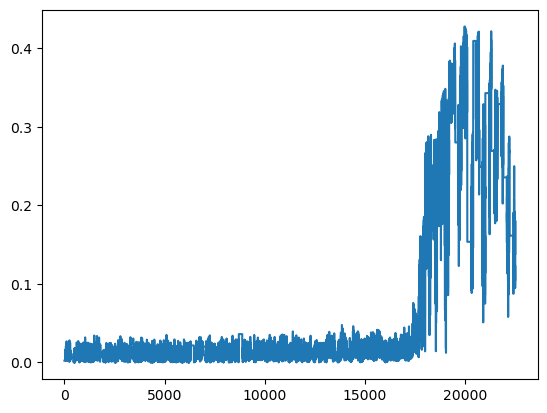

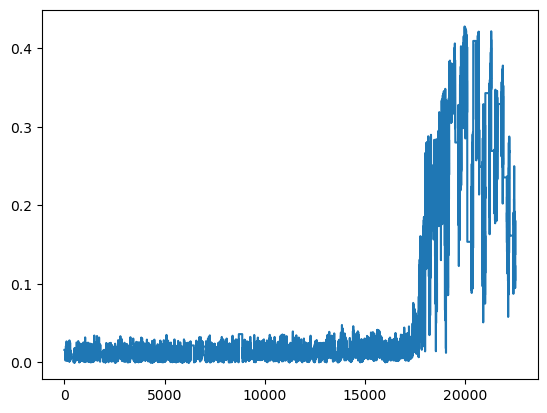

In [103]:
for s in hist_stds:
    plt.plot(s)
    plt.show()

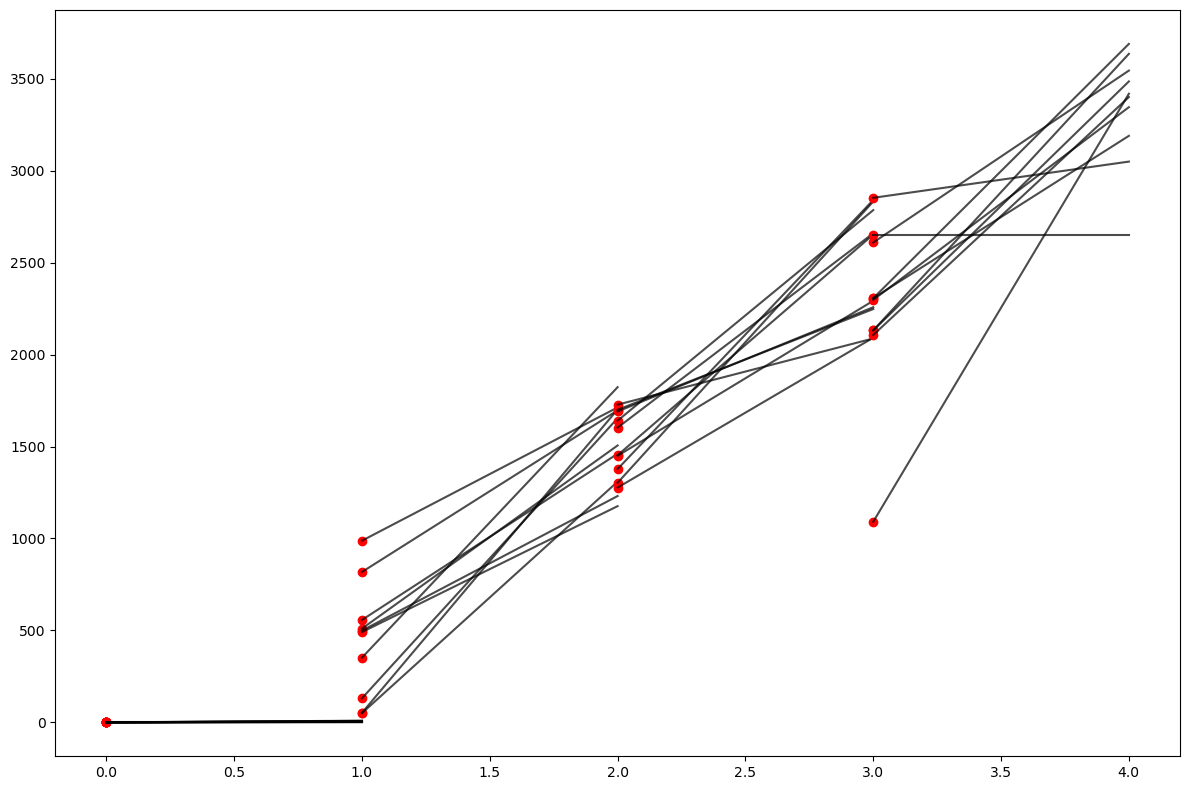

In [139]:
plt.figure(figsize=(12,8))
IDs_temp=IDs[:5]
ngens = IDs_temp.shape[0]
for gen in range(ngens-1):
    parents = IDs_temp[gen,:,0][:10]
    yoff    = parents.min()
    kids    = IDs_temp[gen,:,1][:10]
    yoff2   = kids.min()
    plt.plot([gen for _ in range(len(parents))], parents ,"o",color="red")
    for p,k in zip(parents, kids):
        plt.plot([gen,gen+1], [p,k], color="black",alpha=0.7)
plt.tight_layout()
plt.show()